# Entraînement du Modèle Smart Recycle avec PyTorch & MPS (ResNet50)

Ce notebook permet d'entraîner un modèle de classification d'images (ResNet50) sur le dataset TrashNet.
Il est optimisé pour les Mac Apple Silicon (M1/M2/M3) en utilisant l'accélération MPS (Metal Performance Shaders).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import time
import os
import copy
import matplotlib.pyplot as plt

# Vérification du device (MPS pour Mac, CUDA pour NVIDIA, CPU sinon)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Utilisation du device : {device}")

Utilisation du device : mps


## 1. Préparation des Données

In [2]:
# Transformations : Augmentation des données pour la robustesse + Normalisation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom moins agressif
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),      # Rotation +/- 15 degrés
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Variations d'éclairage
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data'  # On suppose que le notebook est dans 01_IA_LAB/notebooks/
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes : {class_names}")
print(f"Images Train : {dataset_sizes['train']}")
print(f"Images Val : {dataset_sizes['val']}")

Classes : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Images Train : 2019
Images Val : 508


## 2. Chargement du Modèle (Transfer Learning)

In [3]:
model_ft = models.resnet50(pretrained=True)

# On gèle les poids (optionnel, selon stratégie)
# for param in model_ft.parameters():
#     param.requires_grad = False

# Remplacement de la dernière couche fully connected
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/ramadane/Documents/GitHub/smart-recycle-project/venv/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramadane/Documents/GitHub/smart-recycle-project/venv/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. Boucle d'Entraînement

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Stockage de l'historique
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Ajout à l'historique
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [5]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15) # Augmentation à 15 epochs

Epoch 0/14
----------
train Loss: 1.2102 Acc: 0.5745
val Loss: 0.6184 Acc: 0.8031

Epoch 1/14
----------
train Loss: 0.5589 Acc: 0.8187
val Loss: 0.4307 Acc: 0.8484

Epoch 2/14
----------
train Loss: 0.3669 Acc: 0.8796
val Loss: 0.3406 Acc: 0.8957

Epoch 3/14
----------
train Loss: 0.2844 Acc: 0.9074
val Loss: 0.3335 Acc: 0.8976

Epoch 4/14
----------
train Loss: 0.1970 Acc: 0.9366
val Loss: 0.2821 Acc: 0.9094

Epoch 5/14
----------
train Loss: 0.1531 Acc: 0.9529
val Loss: 0.2847 Acc: 0.9114

Epoch 6/14
----------
train Loss: 0.1228 Acc: 0.9633
val Loss: 0.2928 Acc: 0.9075

Epoch 7/14
----------
train Loss: 0.0903 Acc: 0.9742
val Loss: 0.2776 Acc: 0.9114

Epoch 8/14
----------
train Loss: 0.0825 Acc: 0.9772
val Loss: 0.2901 Acc: 0.9075

Epoch 9/14
----------
train Loss: 0.0803 Acc: 0.9817
val Loss: 0.2806 Acc: 0.9094

Epoch 10/14
----------
train Loss: 0.0819 Acc: 0.9797
val Loss: 0.2778 Acc: 0.9154

Epoch 11/14
----------
train Loss: 0.0767 Acc: 0.9832
val Loss: 0.2432 Acc: 0.9193

Ep

## 4. Visualisation des Performances

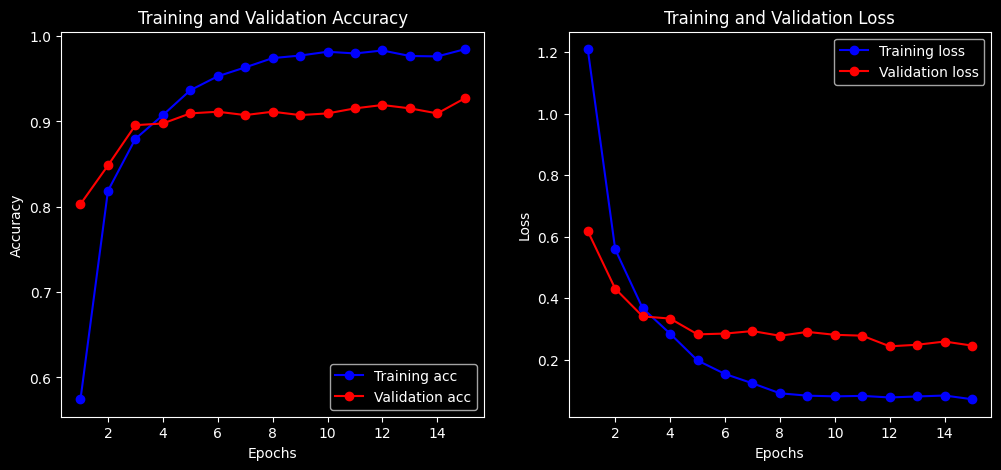

In [6]:
def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

## 5. Sauvegarde du Modèle

In [7]:
import os

save_path = '../models/waste_model.pth'
torch.save(model_ft.state_dict(), save_path)
print(f"Modèle sauvegardé dans {save_path}")

Modèle sauvegardé dans ../models/waste_model.pth
